In [42]:
import importlib

#Py-ART, simply the best sowftware around.. Give those guys a grant
import cartopy
import pyart
#timezone info
import pytz
import glob
import sys
#plotting
from matplotlib import pyplot as plt

from gc import collect
#plotting on a maop

import operator

import xarray as xr
import netCDF4

import scipy.ndimage as ndimage

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from cmac import cmac, quicklooks, get_sounding_times, get_sounding_file_name, config, cmac_processing
import copy
import matplotlib.colors as mc
import matplotlib.ticker as mt
import matplotlib.font_manager as fm
from datetime import datetime

from dask.distributed import Client, progress, metrics, LocalCluster


import os

%matplotlib inline

In [30]:
experiment = 'xsapr_i5_ppi'

meta_config = config.get_metadata(experiment)
cmac_config = config.get_cmac_values(experiment)
field_config = config.get_field_names(experiment)


temp_field = field_config['temperature']
alt_field = field_config['altitude']
vel_field = field_config['velocity']

#field_config['reflectivity'] = 'uncorrected_reflectivity_h'
#field_config['phidp'] = 'uncorrected_differential_phase'

ref_offset = cmac_config['ref_offset']
self_const = cmac_config['self_const']

In [31]:
get

NameError: name 'get' is not defined

In [32]:
field_config['phidp'] = 'differential_phase'
verbose = True
sweep = 2

In [33]:
# 24 may 20z
soundings_directory = '/lustre/or-hydra/cades-arm/proj-shared/data_transfer/sgp/sgpsondewnpnC1.b1/'
radar_directory = '/lustre/or-hydra/cades-arm/proj-shared/scanning_collab/kdp_sec/ppi/2018/0524/'
inf = 'sgpxsaprppiI5.20180524.204213.iris'
inf2 = 'sgpxsaprppiI5.20180524.173213.iris'
#radar = pyart.io.read(radar_directory + inf2)

In [34]:
ex_dir = '/lustre/or-hydra/cades-arm/proj-shared/scanning_collab/'
files_I5_ppi = [f for f in glob.glob(ex_dir + "**/sgpxsaprppiI5*.iris", recursive=True)]
files_I6_ppi = [f for f in glob.glob(ex_dir + "**/sgpxsaprppiI6*.iris", recursive=True)]
files_I4_ppi = [f for f in glob.glob(ex_dir + "**/sgpxsaprppiI4*.iris", recursive=True)]

files_I4_ppi.sort()
files_I5_ppi.sort()
files_I6_ppi.sort()


In [193]:
radar = pyart.io.read(files_I5_ppi[210])

In [194]:
rlat = radar.latitude['data'][0]
rlon = radar.longitude['data'][0]


#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Central')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = '%.1f' % radar.fixed_angle['data'][sweep] + ' Degree sweep ' +local_time.strftime('%A %B %d at %I:%M %p GMT%Z')
print(fancy_date_string)

10.5 Degree sweep Thursday May 24 at 03:26 PM GMTCDT


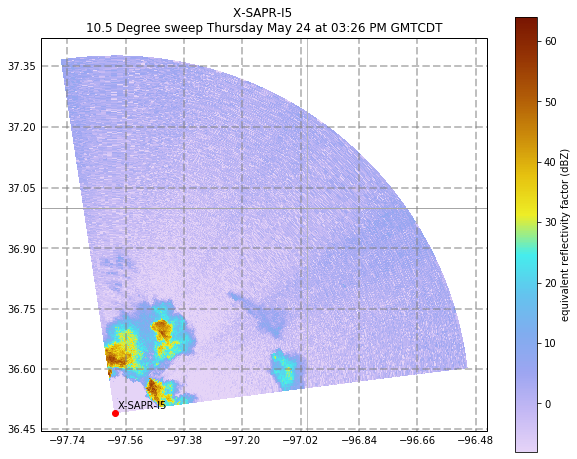

In [195]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'X-SAPR-I5 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64)
#min_lon=-65.1, min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 
# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='X-SAPR-I5')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

datetime.datetime(2018, 3, 31, 23, 30)

In [283]:
soundings_directory = '/lustre/or-hydra/cades-arm/proj-shared/data_transfer/sgp/sgpsondewnpnC1.b1/'

sonds = os.listdir(soundings_directory)
sonds.sort()
mydts = [datetime.strptime(thiss.split('.')[2]+thiss.split('.')[3], '%Y%m%d%H%M%S') for thiss in sonds]
sfn = 'sgpsondewnpnC1.b1'
# Retrieve closest sonde in time to the time of the radar file.
closest_time = min(
    mydts, key=lambda d: abs(d - time_at_start_of_radar))
sonde_file = get_sounding_file_name(
    soundings_directory, sfn, closest_time)
sonde = netCDF4.Dataset(sonde_file+'.v0')

/lustre/or-hydra/cades-arm/proj-shared/data_transfer/sgp/sgpsondewnpnC1.b1/sgpsondewnpnC1.b1.20180524.172900.cdf


In [282]:
time_at_start_of_radar

datetime.datetime(2018, 5, 24, 20, 26, 30, 710000)

In [245]:
get_sounding_file_name(soundings_directory, 'sgpsondewnpn', time_at_start_of_radar)

/lustre/or-hydra/cades-arm/proj-shared/data_transfer/sgp/sgpsondewnpnC1.b1/sgpsondewnpn.20180524.202630.cdf


'/lustre/or-hydra/cades-arm/proj-shared/data_transfer/sgp/sgpsondewnpnC1.b1/sgpsondewnpn.20180524.202630.cdf'

In [247]:
get_sounding_times?

Signature: get_sounding_times(sonde_path, sonde_name)
Docstring:
This function parses the time periods from a list of SGP
sonde files. 
File:      ~/anaconda3/envs/daskenv/lib/python3.6/site-packages/cmac-0.1.0-py3.6.egg/cmac/data_catalouging.py
Type:      function


In [196]:
ncf_sounding = netCDF4.Dataset(soundings_directory + 'sgpsondewnpnC1.b1.20180524.172900.cdf.v0')

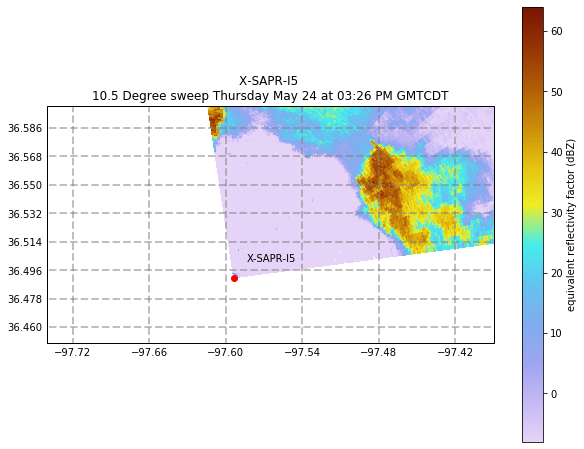

In [197]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'X-SAPR-I5 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-97.39, min_lat=36.45, max_lon=-97.74, max_lat=36.6 )
#min_lon=-97.39, min_lat=36.45, max_lon=-64.6, max_lat=-97.74 
# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='X-SAPR-I5')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

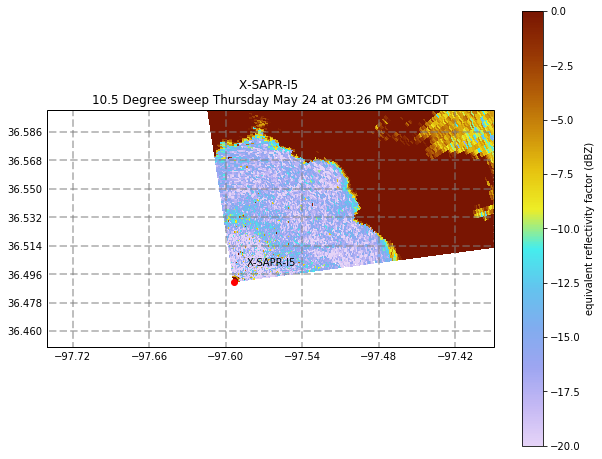

In [198]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'X-SAPR-I5 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-20, vmax=0, min_lon=-97.39, min_lat=36.45, max_lon=-97.74, max_lat=36.6 )
#min_lon=-97.39, min_lat=36.45, max_lon=-64.6, max_lat=-97.74 
# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='X-SAPR-I5')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [200]:
cfld = copy.deepcopy(radar.fields['reflectivity'])
cfld['data'] = cfld['data']* 0
cfld['data'][:, 0:10] = 1

cfld['standard_name'] = 'clutter'
cfld['long_name'] = 'clutter field'
cfld['units'] = 'unitless'
radar.add_field('ground_clutter', cfld, replace_existing=True)

if 'clutter_mask_z_for_texture' not in cmac_config.keys():
        cmac_config['clutter_mask_z_for_texture'] = False

if cmac_config['clutter_mask_z_for_texture']:
    masked_vr = copy.deepcopy(radar.fields[vel_field])
    masked_vr['data'] = np.ma.masked_where(radar.fields['ground_clutter']['data'] == 1, masked_vr['data'])
    masked_vr['data'][radar.fields['ground_clutter']['data'] == 1] = np.nan
    radar.add_field('clutter_masked_velocity', masked_vr, replace_existing=True)

    texture = cmac_processing.get_texture(radar, 'clutter_masked_velocity')
    texture['data'][np.isnan(texture['data'])] = 0.0
else:
    texture = cmac_processing.get_texture(radar, vel_field)
    
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(ncf_sounding.variables[temp_field][:], 
                                                        ncf_sounding.variables[alt_field][:], 
                                                        radar)


snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)

radar.add_field('sounding_temperature', temp_dict, replace_existing=True)
radar.add_field('height', z_dict, replace_existing=True)
radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)
radar.add_field('velocity_texture', texture, replace_existing=True)

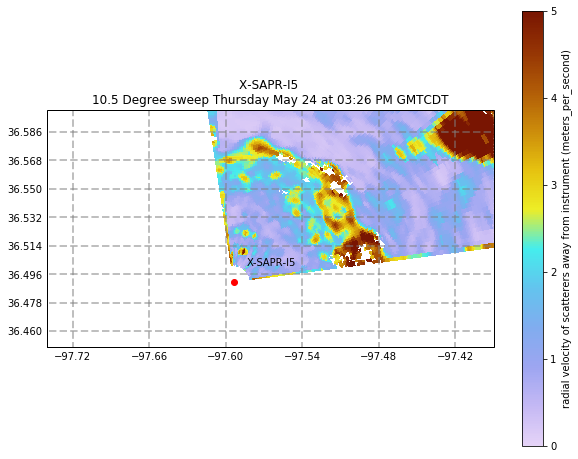

In [203]:
#hh = plt.hist(radar.fields['velocity_texture']['data'].flatten(), bins=100)
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'X-SAPR-I5 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'velocity_texture', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5, min_lon=-97.39, min_lat=36.45, max_lon=-97.74, max_lat=36.6 )
#min_lon=-97.39, min_lat=36.45, max_lon=-64.6, max_lat=-97.74 
# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='X-SAPR-I5')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

##
## CMAC calculation using fuzzy logic:
##    Doing multi_trip
##    Doing rain
##    Doing snow
##    Doing no_scatter
##    Doing melting
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 1091, 1091, 1091]), array([23, 24, 25, ..., 63, 64, 65]))
##    Doing hard constraining multi_trip
##     (array([   0,    0,    0, ..., 1091, 1091, 1091]), array([ 731,  732,  733, ...,  998,  999, 1000]))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 1091, 1091, 1091]), array([   0,    1,    2, ...,  998,  999, 1000]))
##    Doing hard constraining rain
##     (array([   0,    0,    0, ..., 1091, 1091, 1091]), array([368, 369, 370, ..., 676, 677, 678]))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 1091, 1091, 1091]), array([ 87,  88,  89, ..., 700, 704, 725]))
2


In [205]:

rhv_field = field_config['cross_correlation_ratio']
ncp_field = field_config['normalized_coherent_power']

if 'mbfs' not in cmac_config:
    cmac_config['mbfs'] = None

if 'hard_const' not in cmac_config:
    cmac_config['hard_const'] = None


my_fuzz, _ = cmac_processing.do_my_fuzz(radar, rhv_field, ncp_field, tex_start=2.5,
                        tex_end=5., 
                        custom_mbfs=cmac_config['mbfs'],
                        custom_hard_constraints=cmac_config['hard_const'],
                        verbose=True)

radar.add_field('gate_id', my_fuzz,
                replace_existing=True)

if 'ground_clutter' in radar.fields.keys():
    # Adding fifth gate id, clutter.
    clutter_data = radar.fields['ground_clutter']['data']
    gate_data = radar.fields['gate_id']['data']
    radar.fields['gate_id']['data'][clutter_data == 1] = 5
    notes = radar.fields['gate_id']['notes']
    radar.fields['gate_id']['notes'] = notes + ',5:clutter'
    radar.fields['gate_id']['valid_max'] = 5
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})

if verbose:
    print('##    gate_id')

cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})

#HARD constraint for lowz
lowz_regs = np.where(radar.fields['reflectivity']['data'] < -10)
radar.fields['gate_id']['data'][lowz_regs] = cat_dict['no_scatter']

##    gate_id


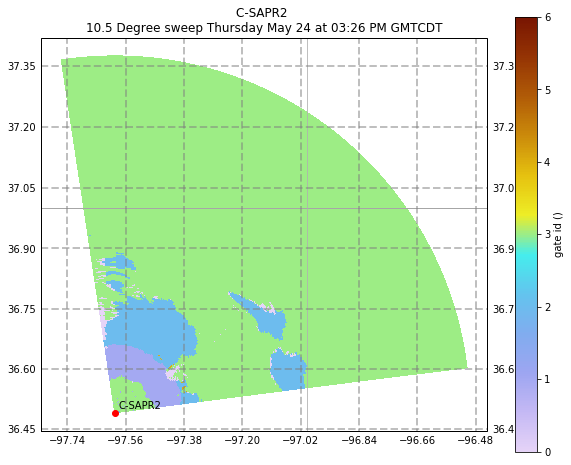

In [206]:
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'gate_id', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=6)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False

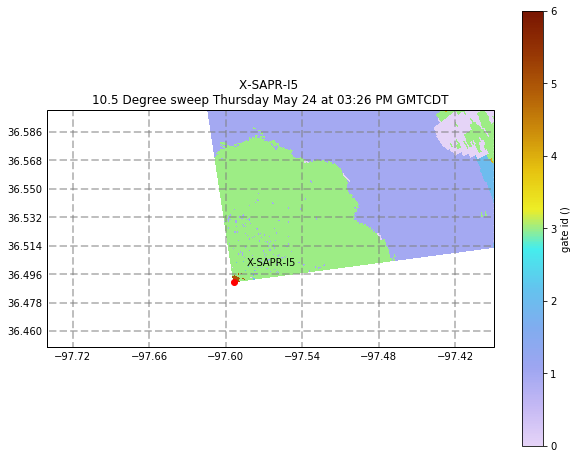

In [207]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'X-SAPR-I5 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'gate_id', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=6, min_lon=-97.39, min_lat=36.45, max_lon=-97.74, max_lat=36.6 )
#min_lon=-97.39, min_lat=36.45, max_lon=-64.6, max_lat=-97.74 
# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='X-SAPR-I5')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [208]:
print(cat_dict)

{'multi_trip': 0, 'rain': 1, 'snow': 2, 'no_scatter': 3, 'melting': 4, 'clutter': 5}


In [210]:
cmac_gates = pyart.correct.GateFilter(radar)
cmac_gates.exclude_all()
cmac_gates.include_equal('gate_id', cat_dict['rain'])
cmac_gates.include_equal('gate_id', cat_dict['melting'])
cmac_gates.include_equal('gate_id', cat_dict['snow'])

cmac_gates_hard = pyart.correct.GateFilter(radar)
cmac_gates_hard.exclude_all()
cmac_gates_hard.include_equal('gate_id', cat_dict['rain'])
cmac_gates_hard.include_equal('gate_id', cat_dict['melting'])
cmac_gates_hard.include_equal('gate_id', cat_dict['snow'])
cmac_gates_hard.exclude_below('reflectivity', 0)

dspcf = pyart.correct.despeckle_field(radar,'differential_phase', gatefilter=cmac_gates_hard )

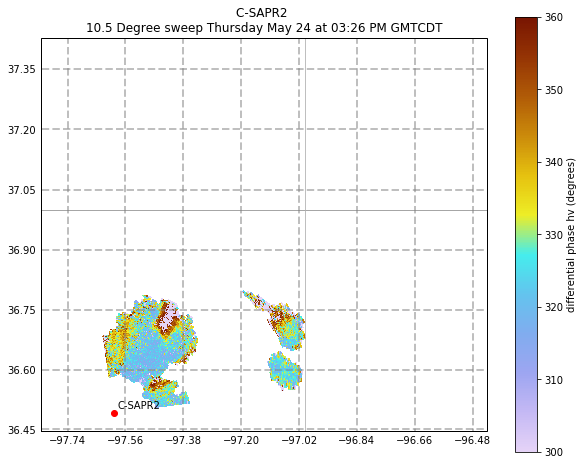

In [211]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'differential_phase', 0, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=300, vmax=360, gatefilter=dspcf )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

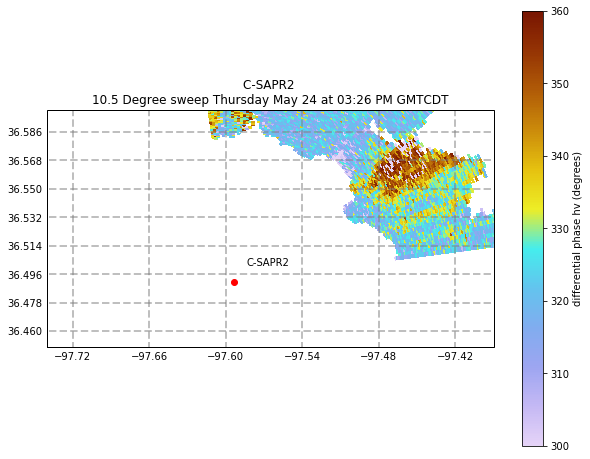

In [212]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'differential_phase', 0, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=300, vmax=360, gatefilter=dspcf,
    min_lon=-97.39, min_lat=36.45, max_lon=-97.74, max_lat=36.6 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [214]:
#radar.gate_altitude['data']
#radar.gate_altitude['data'] = radar.gate_altitude['data'].data

# Create a simulated velocity field from the sonde object.
u_field = field_config['u_wind']
v_field = field_config['v_wind']
u_wind = ncf_sounding.variables[u_field][:]
v_wind = ncf_sounding.variables[v_field][:]
alt_field = field_config['altitude']
sonde_alt = ncf_sounding.variables[alt_field][:]
profile = pyart.core.HorizontalWindProfile.from_u_and_v(
    sonde_alt, u_wind, v_wind)
sim_vel = pyart.util.simulated_vel_from_profile(radar, profile)
radar.add_field('simulated_velocity', sim_vel, replace_existing=True)

corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field=vel_field, ref_vel_field='simulated_velocity',
    keep_original=False, gatefilter=cmac_gates, centered=True)

radar.add_field('corrected_velocity', corr_vel, replace_existing=True)

print('##    corrected_velocity')
print('##    simulated_velocity')

fzl = cmac_processing.get_melt(radar)

unf = pyart.correct.phase_proc.get_phidp_unf_gf(radar, dspcf,
                                                phidp_field=field_config['phidp'],
                                               sys_phase=300., nowrap=100,
                                               ncpts=20)

radar.add_field_like('differential_phase', 'unfolded_differential_phase', unf, replace_existing=True)



##    corrected_velocity
##    simulated_velocity
1758.5


In [215]:
print(radar.fields['differential_phase']['data'][:,0].mean())

197.30792124542126


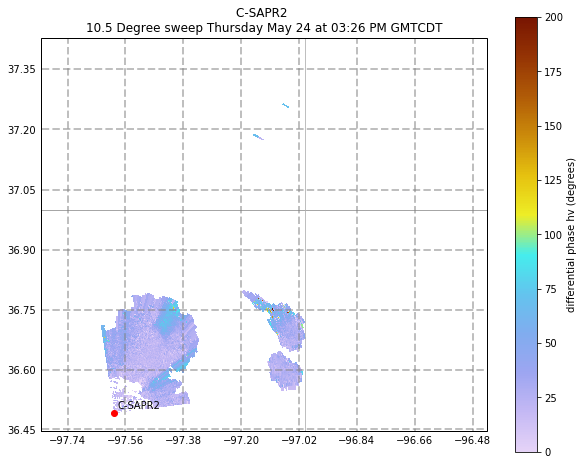

In [218]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'unfolded_differential_phase', 0, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=200, gatefilter=cmac_gates )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [219]:
#pyart.correct.phase_proc.det_sys_phase_gf(radar, cmac_gates, phidp_field=field_config['phidp'], first_gate=30.0)

In [220]:
print(ref_offset, fzl)

0.0 1758.5


In [237]:
# Calculating differential phase fields.
phidp, kdp = pyart.correct.phase_proc_lp_gf(
    radar, gatefilter=dspcf, offset=ref_offset, debug=True,
    nowrap=150, fzl=10000, self_const=self_const, phidp_field=field_config['phidp'])
phidp_filt, kdp_filt = cmac_processing.fix_phase_fields(
    copy.deepcopy(kdp), copy.deepcopy(phidp), radar.range['data'],
    cmac_gates)

radar.add_field('corrected_differential_phase', phidp,
                replace_existing=True)
radar.add_field('filtered_corrected_differential_phase', phidp_filt,
                replace_existing=True)
radar.add_field('corrected_specific_diff_phase', kdp,
                replace_existing=True)
radar.add_field('filtered_corrected_specific_diff_phase', kdp_filt,
                replace_existing=True)

print('##    corrected_specific_diff_phase')
print('##    filtered_corrected_specific_diff_phase')
print('##    corrected_differential_phase')
print('##    filtered_corrected_differential_phase')

Unfolding
Exec time:  1.5586650371551514
Doing  0
Doing  1
Doing  2
Doing  3
Doing  4
Doing  5
Doing  6
Doing  7
Doing  8
Doing  9
Doing  10
Doing  11
(1092, 1000)
(1092, 1001)
##    corrected_specific_diff_phase
##    filtered_corrected_specific_diff_phase
##    corrected_differential_phase
##    filtered_corrected_differential_phase


In [238]:
field_config['phidp']

'differential_phase'

In [239]:
radar.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase', 'ground_clutter', 'sounding_temperature', 'height', 'signal_to_noise_ratio', 'velocity_texture', 'gate_id', 'simulated_velocity', 'corrected_velocity', 'unfolded_differential_phase', 'corrected_differential_phase', 'filtered_corrected_differential_phase', 'corrected_specific_diff_phase', 'filtered_corrected_specific_diff_phase', 'vulp_differential_phase', 'vulp_specific_diff_phase', 'mes_differential_phase_forward', 'mes_differential_phase_reverse', 'mes_specific_diff_phase'])

In [240]:
print(radar.fields['filtered_corrected_differential_phase']['data'].mean())

2.2381560494266504


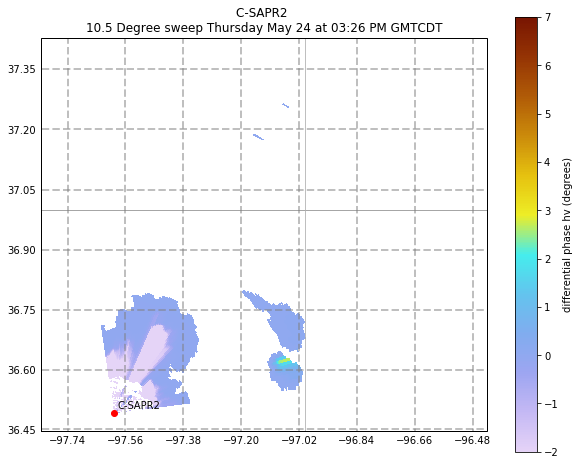

In [241]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_differential_phase', 0, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-2, vmax=7, gatefilter=cmac_gates )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

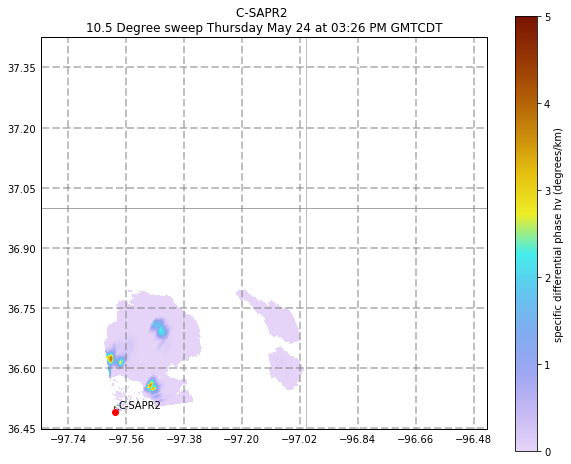

In [242]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_specific_diff_phase', 1, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5, gatefilter=cmac_gates )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [226]:
radar.fields['filtered_corrected_differential_phase']['data'].max()

6.51571918337378

In [227]:
vpkdp, vpphidp = pyart.retrieve.kdp_proc.kdp_vulpiani(radar, 
                                                      gatefilter=dspcf, 
                                                      fill_value=None, 
                                                      psidp_field=None, 
                                                      kdp_field=None, 
                                                      phidp_field='unfolded_differential_phase', 
                                                      band='X', 
                                                      windsize=10, 
                                                      n_iter=10, 
                                                      interp=False, 
                                                      prefilter_psidp=False, 
                                                      filter_opt=None, parallel=False)

In [228]:
radar.add_field('vulp_differential_phase', vpphidp,
                replace_existing=True)
radar.add_field('vulp_specific_diff_phase', vpkdp,
                replace_existing=True)


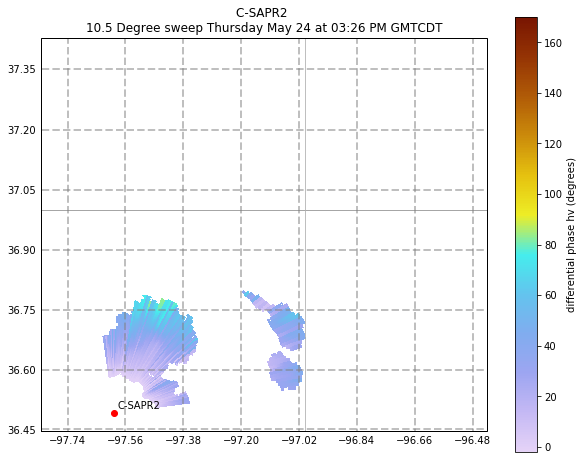

In [229]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'vulp_differential_phase', 0, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-2, vmax=170, gatefilter=cmac_gates )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

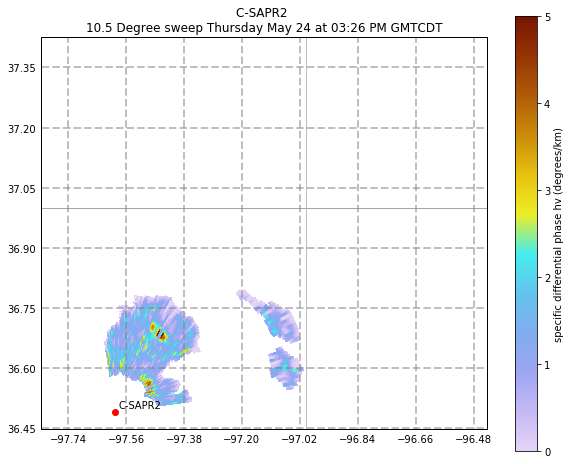

In [236]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'vulp_specific_diff_phase', 1, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5, gatefilter=cmac_gates )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [232]:
mkdp, mkphf, mkphr = pyart.retrieve.kdp_proc.kdp_maesaka(radar, 
                                                         gatefilter=dspcf, 
                                                         method='cg', 
                                                         backscatter=None,
                                                         Clpf=1.0, 
                                                         length_scale=None, 
                                                         first_guess=0.01,
                                                         finite_order='low',
                                                         fill_value=None, 
                                                         proc=1, 
                                                         psidp_field=None, 
                                                         kdp_field=None, 
                                                         phidp_field='unfolded_differential_phase',
                                                         debug=False, 
                                                         verbose=False)

radar.add_field('mes_differential_phase_forward', mkphf,
                replace_existing=True)
radar.add_field('mes_differential_phase_reverse', mkphr,
                replace_existing=True)

radar.add_field('mes_specific_diff_phase', mkdp,
                replace_existing=True)


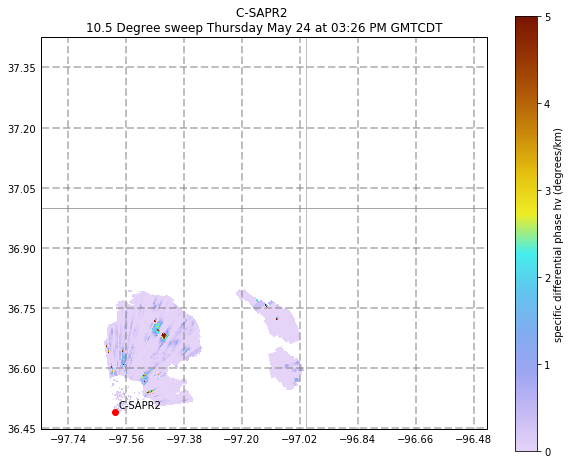

In [235]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'mes_specific_diff_phase', 1, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5, gatefilter=cmac_gates )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [72]:
#lets package
def do_cmac_i5_sec(filename):
    from cmac import cmac, quicklooks, get_sounding_times, get_sounding_file_name, config, cmac_processing
    def file_formatter(stime, site, scanmode, base, expr):
        #base/year/monthday
        
        mday = stime.strftime('%m%d')
        odir = os.path.join(base,
                            expr.lower(),
                            scanmode,
                            stime.strftime('%Y'),
                            mday)
        fname1 = 'sgpxsapr' + scanmode + site + stime.strftime('.%Y%m%d.%H%M%S')
        return odir, fname1
    
    verbose = True
    experiment = 'xsapr_i5_ppi'
    meta_config = config.get_metadata(experiment)
    cmac_config = config.get_cmac_values(experiment)
    field_config = config.get_field_names(experiment)


    temp_field = field_config['temperature']
    alt_field = field_config['altitude']
    vel_field = field_config['velocity']

    #field_config['reflectivity'] = 'uncorrected_reflectivity_h'
    #field_config['phidp'] = 'uncorrected_differential_phase'

    ref_offset = cmac_config['ref_offset']
    self_const = cmac_config['self_const']
    
    field_config['phidp'] = 'differential_phase'
    soundings_directory = '/lustre/or-hydra/cades-arm/proj-shared/data_transfer/sgp/sgpsondewnpnC1.b1/'
    try:
        radar = pyart.io.read(filename)
        index_at_start = radar.sweep_start_ray_index['data'][0]
        time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                          radar.time['units'])

        sonds = os.listdir(soundings_directory)
        sonds.sort()
        mydts = [datetime.strptime(thiss.split('.')[2]+thiss.split('.')[3], '%Y%m%d%H%M%S') for thiss in sonds]
        sfn = 'sgpsondewnpnC1.b1'
        # Retrieve closest sonde in time to the time of the radar file.
        closest_time = min(
            mydts, key=lambda d: abs(d - time_at_start_of_radar))
        sonde_file = get_sounding_file_name(
            soundings_directory, sfn, closest_time)
        ncf_sounding = netCDF4.Dataset(sonde_file+'.v0')
        cfld = copy.deepcopy(radar.fields['reflectivity'])
        cfld['data'] = cfld['data']* 0
        cfld['data'][:, 0:10] = 1

        cfld['standard_name'] = 'clutter'
        cfld['long_name'] = 'clutter field'
        cfld['units'] = 'unitless'
        radar.add_field('ground_clutter', cfld, replace_existing=True)
        
        del cfld

        if 'clutter_mask_z_for_texture' not in cmac_config.keys():
                cmac_config['clutter_mask_z_for_texture'] = False

        if cmac_config['clutter_mask_z_for_texture']:
            masked_vr = copy.deepcopy(radar.fields[vel_field])
            masked_vr['data'] = np.ma.masked_where(radar.fields['ground_clutter']['data'] == 1, masked_vr['data'])
            masked_vr['data'][radar.fields['ground_clutter']['data'] == 1] = np.nan
            radar.add_field('clutter_masked_velocity', masked_vr, replace_existing=True)

            texture = cmac_processing.get_texture(radar, 'clutter_masked_velocity')
            texture['data'][np.isnan(texture['data'])] = 0.0
        else:
            texture = cmac_processing.get_texture(radar, vel_field)

        z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(ncf_sounding.variables[temp_field][:], 
                                                                ncf_sounding.variables[alt_field][:], 
                                                                radar)


        snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)

        radar.add_field('sounding_temperature', temp_dict, replace_existing=True)
        radar.add_field('height', z_dict, replace_existing=True)
        radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)
        radar.add_field('velocity_texture', texture, replace_existing=True)
        
        del texture, snr, z_dict, temp_dict


        rhv_field = field_config['cross_correlation_ratio']
        ncp_field = field_config['normalized_coherent_power']

        if 'mbfs' not in cmac_config:
            cmac_config['mbfs'] = None

        if 'hard_const' not in cmac_config:
            cmac_config['hard_const'] = None


        my_fuzz, _ = cmac_processing.do_my_fuzz(radar, rhv_field, ncp_field, tex_start=2.5,
                                tex_end=5., 
                                custom_mbfs=cmac_config['mbfs'],
                                custom_hard_constraints=cmac_config['hard_const'],
                                verbose=True)

        radar.add_field('gate_id', my_fuzz,
                        replace_existing=True)
        
        del my_fuzz

        if 'ground_clutter' in radar.fields.keys():
            # Adding fifth gate id, clutter.
            clutter_data = radar.fields['ground_clutter']['data']
            gate_data = radar.fields['gate_id']['data']
            radar.fields['gate_id']['data'][clutter_data == 1] = 5
            notes = radar.fields['gate_id']['notes']
            radar.fields['gate_id']['notes'] = notes + ',5:clutter'
            radar.fields['gate_id']['valid_max'] = 5
        cat_dict = {}
        for pair_str in radar.fields['gate_id']['notes'].split(','):
            cat_dict.update(
                {pair_str.split(':')[1]:int(pair_str.split(':')[0])})

        if verbose:
            print('##    gate_id')

        cat_dict = {}
        for pair_str in radar.fields['gate_id']['notes'].split(','):
            cat_dict.update(
                {pair_str.split(':')[1]:int(pair_str.split(':')[0])})
        

        #HARD constraint for lowz
        lowz_regs = np.where(radar.fields['reflectivity']['data'] < -10)
        radar.fields['gate_id']['data'][lowz_regs] = cat_dict['no_scatter']
        del lowz_regs

        cmac_gates = pyart.correct.GateFilter(radar)
        cmac_gates.exclude_all()
        cmac_gates.include_equal('gate_id', cat_dict['rain'])
        cmac_gates.include_equal('gate_id', cat_dict['melting'])
        cmac_gates.include_equal('gate_id', cat_dict['snow'])

        cmac_gates_hard = pyart.correct.GateFilter(radar)
        cmac_gates_hard.exclude_all()
        cmac_gates_hard.include_equal('gate_id', cat_dict['rain'])
        cmac_gates_hard.include_equal('gate_id', cat_dict['melting'])
        cmac_gates_hard.include_equal('gate_id', cat_dict['snow'])
        cmac_gates_hard.exclude_below('reflectivity', 0)

        dspcf = pyart.correct.despeckle_field(radar,'differential_phase', gatefilter=cmac_gates_hard )

        #radar.gate_altitude['data']
        #radar.gate_altitude['data'] = radar.gate_altitude['data'].data

        # Create a simulated velocity field from the sonde object.
        u_field = field_config['u_wind']
        v_field = field_config['v_wind']
        u_wind = ncf_sounding.variables[u_field][:]
        v_wind = ncf_sounding.variables[v_field][:]
        alt_field = field_config['altitude']
        sonde_alt = ncf_sounding.variables[alt_field][:]
        profile = pyart.core.HorizontalWindProfile.from_u_and_v(
            sonde_alt, u_wind, v_wind)
        sim_vel = pyart.util.simulated_vel_from_profile(radar, profile)
        radar.add_field('simulated_velocity', sim_vel, replace_existing=True)

        corr_vel = pyart.correct.dealias_region_based(
            radar, vel_field=vel_field, ref_vel_field='simulated_velocity',
            keep_original=False, gatefilter=cmac_gates, centered=True)

        radar.add_field('corrected_velocity', corr_vel, replace_existing=True)
        
        del corr_vel, sim_vel

        print('##    corrected_velocity')
        print('##    simulated_velocity')

        fzl = cmac_processing.get_melt(radar)

        unf = pyart.correct.phase_proc.get_phidp_unf_gf(radar, dspcf,
                                                        phidp_field=field_config['phidp'],
                                                       sys_phase=300., nowrap=100,
                                                       ncpts=20)

        radar.add_field_like('differential_phase', 'unfolded_differential_phase', 
                             unf, replace_existing=True)

        # Calculating differential phase fields.
        phidp, kdp = pyart.correct.phase_proc_lp_gf(
            radar, gatefilter=dspcf, offset=ref_offset, debug=True,
            nowrap=150, fzl=10000, self_const=self_const, phidp_field=field_config['phidp'])
        phidp_filt, kdp_filt = cmac_processing.fix_phase_fields(
            copy.deepcopy(kdp), copy.deepcopy(phidp), radar.range['data'],
            cmac_gates)

        radar.add_field('corrected_differential_phase', phidp,
                        replace_existing=True)
        radar.add_field('filtered_corrected_differential_phase', phidp_filt,
                        replace_existing=True)
        radar.add_field('corrected_specific_diff_phase', kdp,
                        replace_existing=True)
        radar.add_field('filtered_corrected_specific_diff_phase', kdp_filt,
                        replace_existing=True)
        
        del kdp_filt, kdp, phidp_filt, phidp, unf

        print('##    corrected_specific_diff_phase')
        print('##    filtered_corrected_specific_diff_phase')
        print('##    corrected_differential_phase')
        print('##    filtered_corrected_differential_phase')

        vpkdp, vpphidp = pyart.retrieve.kdp_proc.kdp_vulpiani(radar, 
                                                          gatefilter=dspcf, 
                                                          fill_value=None, 
                                                          psidp_field=None, 
                                                          kdp_field=None, 
                                                          phidp_field='unfolded_differential_phase', 
                                                          band='X', 
                                                          windsize=10, 
                                                          n_iter=10, 
                                                          interp=False, 
                                                          prefilter_psidp=False, 
                                                          filter_opt=None, parallel=False)

        radar.add_field('vulp_differential_phase', vpphidp,
                    replace_existing=True)
        radar.add_field('vulp_specific_diff_phase', vpkdp,
                        replace_existing=True)
        
        del vpkdp
        del vpphidp

        print('##    Vulpani')
        mkdp, mkphf, mkphr = pyart.retrieve.kdp_proc.kdp_maesaka(radar, 
                                                             gatefilter=dspcf, 
                                                             method='cg', 
                                                             backscatter=None,
                                                             Clpf=1.0, 
                                                             length_scale=None, 
                                                             first_guess=0.01,
                                                             finite_order='low',
                                                             fill_value=None, 
                                                             proc=1, 
                                                             psidp_field=None, 
                                                             kdp_field=None, 
                                                             phidp_field='unfolded_differential_phase',
                                                             debug=False, 
                                                             verbose=False)
        
       
        radar.add_field('mes_differential_phase_forward', mkphf,
                        replace_existing=True)
        radar.add_field('mes_differential_phase_reverse', mkphr,
                        replace_existing=True)

        radar.add_field('mes_specific_diff_phase', mkdp,
                        replace_existing=True)
        

        del mkdp
        del mkphf
        del mkphr

        print('##    Measaka')
        odir, fnout = file_formatter(time_at_start_of_radar, 'I5', 'sec', 
                                     '/lustre/or-hydra/cades-arm/proj-shared/scanning_collab', 'processed')
        print(odir)
        print(fnout)
        filenameout = os.path.join(odir, fnout) + '.nc'
        try:
            os.makedirs(odir)
        except:
            pass
        pyart.io.write_cfradial(filenameout, radar)
       
        ncf_sounding.close()
        tgates = float(radar.ngates*radar.nrays)
        zdat = radar.fields['gate_id']['data']

        rain = float(len(np.where(zdat == cat_dict['rain'])[0]))/tgates
        snow = float(len(np.where(zdat == cat_dict['snow'])[0]))/tgates
        del radar, cmac_gates, cmac_gates_hard, dspcf
        rv = (rain, snow)
    except Exception as e:
        rv = 'Error ' + str(e)
    
    collect()
    return rv
    
    
    

    

'/lustre/or-hydra/cades-arm/proj-shared/scanning_collab/kdp_sec/ppi/2018/0524/sgpxsaprppiI5.20180524.202613.iris'

In [73]:
client.restart()
client = Client('arm-jupyter.ornl.gov:5555')


In [74]:
client

Client Scheduler: tcp://arm-jupyter.ornl.gov:5555 Dashboard: http://arm-jupyter.ornl.gov:8787/status,Cluster Workers: 30 Cores: 180 Memory: 1.28 TB


In [75]:
future = client.map(do_cmac_i5_sec, files_I5_ppi)
progress(future)

VBox()

In [77]:
future[0]

<Future: status: error, type: tuple, key: do_cmac_i5_sec-00e0807bad6e57e71551293cb0343fa6>

In [71]:
my_data = client.gather(future)

KilledWorker: ('do_cmac_i5_sec-1e0af9e05f91e1ef594199bccc3991fe', <Worker 'tcp://172.23.217.90:35849', memory: 0, processing: 1538>)

In [76]:
my_data

["Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referenced before assignment",
 "Error local variable 'my_fuzz' referen

In [49]:

#simple deletes
#1377
#1hr 1min

#comprehensive deletes
#1538
#1hr 1 min 

#best effort 
#3411
#1hr 1 min

